<a href="https://colab.research.google.com/github/arifpras/ExpectedDemand/blob/main/20240514_podem01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div class="markdown-google-sans">

  <h1> Predicting Demand in the Primary Market: Pycaret</h1>
</div>

<div class="markdown-google-sans">

## <strong> Data Preparation </strong>
</div>

## Libraries

In [ ]:
%%capture

# !pip install -U scikit-learn==0.24.2
# !pip install -U imbalanced-learn

# %pip install openpyxl
# %pip install shap
# %pip install pycaret

!pip show pycaret || pip install pycaret

In [ ]:
# Subsequent cells can use the installed library
import pycaret
pycaret.__version__

'3.3.2'

In [ ]:
from pycaret.regression import *

import numpy as np
import pandas as pd
import openpyxl as xl
import matplotlib.pyplot as plt
import seaborn as sns

## Database

### Load

In [ ]:
df_train00 = pd.read_excel('/content/drive/MyDrive/00database/db_monthfrac.xlsx', sheet_name='database')
df_train00['incoming_bid'] = df_train00['incoming_bid'].astype(float)
df_train00['issuance_date'] = pd.to_datetime(df_train00['issuance_date'], format='%Y-%m-%d')

df_train00.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1945 entries, 0 to 1944
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   issued_series     1945 non-null   object        
 1   issuance_date     1945 non-null   datetime64[ns]
 2   issuance_year     1945 non-null   int64         
 3   issuance_week     1945 non-null   int64         
 4   monthfrac         1945 non-null   int64         
 5   eid_weeks         1945 non-null   int64         
 6   srbi_issuance     1945 non-null   int64         
 7   vix_indicator     1945 non-null   int64         
 8   bi_covid          1945 non-null   int64         
 9   gso_issuance      1945 non-null   int64         
 10  investment_grade  1945 non-null   int64         
 11  incoming_bid      1945 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(9), object(1)
memory usage: 182.5+ KB


In [ ]:
df_train00['issued_series'].value_counts()

issued_series
sun10    299
sun20    294
spn12    279
sun15    279
sun05    273
spn03    245
sun30    177
spn09     76
sun07     11
sun08      9
sun04      1
vr04       1
sun02      1
Name: count, dtype: int64

In [ ]:
df_train00.describe()

,issuance_date,issuance_year,issuance_week,monthfrac,eid_weeks,srbi_issuance,vix_indicator,bi_covid,gso_issuance,investment_grade,incoming_bid
count,1945,1945.000000,1945.000000,1945.000000,1945.000000,1945.000000,1945.000000,1945.000000,1945.000000,1945.000000,1.945000e+03
mean,2017-10-04 22:27:27.300771072,2017.315167,24.271979,124.504370,0.081748,0.051414,0.080206,0.242674,0.022108,0.863753,6.294898e+06
min,2009-01-13 00:00:00,2009.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,2014-02-05 00:00:00,2014.000000,12.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.400000e+06
50%,2018-07-17 00:00:00,2018.000000,24.000000,119.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.450000e+06
75%,2021-06-08 00:00:00,2021.000000,36.000000,189.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,8.005000e+06
max,2024-04-30 00:00:00,2024.000000,51.000000,367.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.516780e+07
std,NaN,4.355818,14.093294,108.610264,0.274051,0.220897,0.271681,0.428810,0.147073,0.343139,5.919899e+06


<Axes: xlabel='incoming_bid', ylabel='issuance_week'>

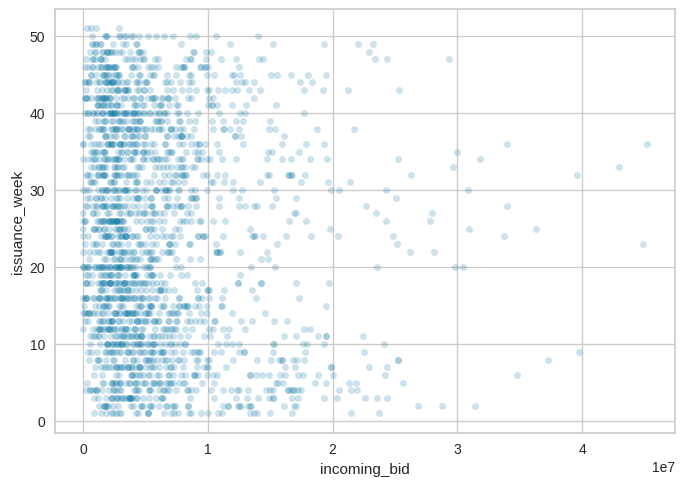

In [ ]:
df_train00.plot(kind = 'scatter', x = 'incoming_bid', y = 'issuance_week', alpha = 0.2)

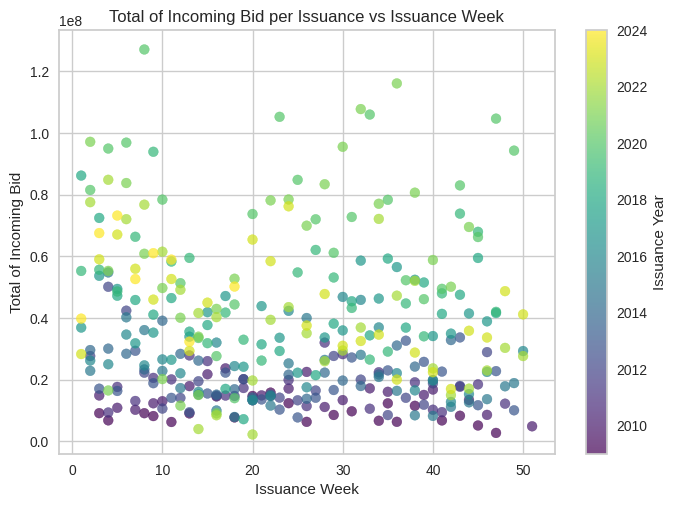

In [ ]:
# import matplotlib.pyplot as plt

grouped_series01 = df_train00.groupby(['issuance_date']).agg({
    'incoming_bid': 'sum',
    'issuance_week': 'mean',
    'issuance_year': 'mean'
}).reset_index()

# Convert 'issuance_year' to integer
grouped_series01['issuance_year'] = grouped_series01['issuance_year'].astype(int)


# Scatter plot
# plt.figure(figsize=(10, 6))
plt.scatter(grouped_series01['issuance_week'], grouped_series01['incoming_bid'], s=50, c=grouped_series01['issuance_year'], alpha=0.7, cmap='viridis')
plt.title('Total of Incoming Bid per Issuance vs Issuance Week')
plt.xlabel('Issuance Week')
plt.ylabel('Total of Incoming Bid')
plt.colorbar(label='Issuance Year')
plt.grid(True)
plt.show()

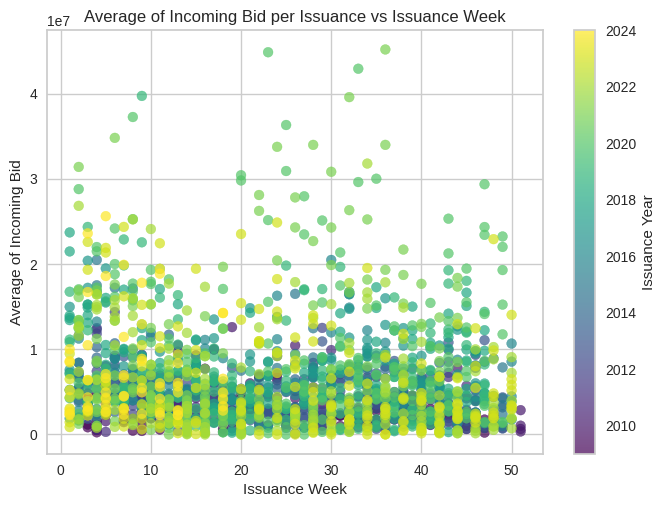

In [ ]:
# import matplotlib.pyplot as plt

grouped_series02 = df_train00.groupby(['issuance_date', 'issued_series']).agg({
    'incoming_bid': 'mean', #average
    'issuance_week': 'mean',
    'issuance_year': 'mean'
}).reset_index()

# Convert 'issuance_year' to integer
grouped_series02['issuance_year'] = grouped_series02['issuance_year'].astype(int)


# Scatter plot
# plt.figure(figsize=(10, 6))
plt.scatter(grouped_series02['issuance_week'], grouped_series02['incoming_bid'], s=50, c=grouped_series02['issuance_year'], alpha=0.7, cmap='viridis')
plt.title('Average of Incoming Bid per Issuance vs Issuance Week')
plt.xlabel('Issuance Week')
plt.ylabel('Average of Incoming Bid')
plt.colorbar(label='Issuance Year')
plt.grid(True)
plt.show()

In [ ]:
# sns.catplot(x='issued_series', y='incoming_bid', data=grouped_series02,
#                 kind='boxen', col='issuance_year', col_wrap=2)

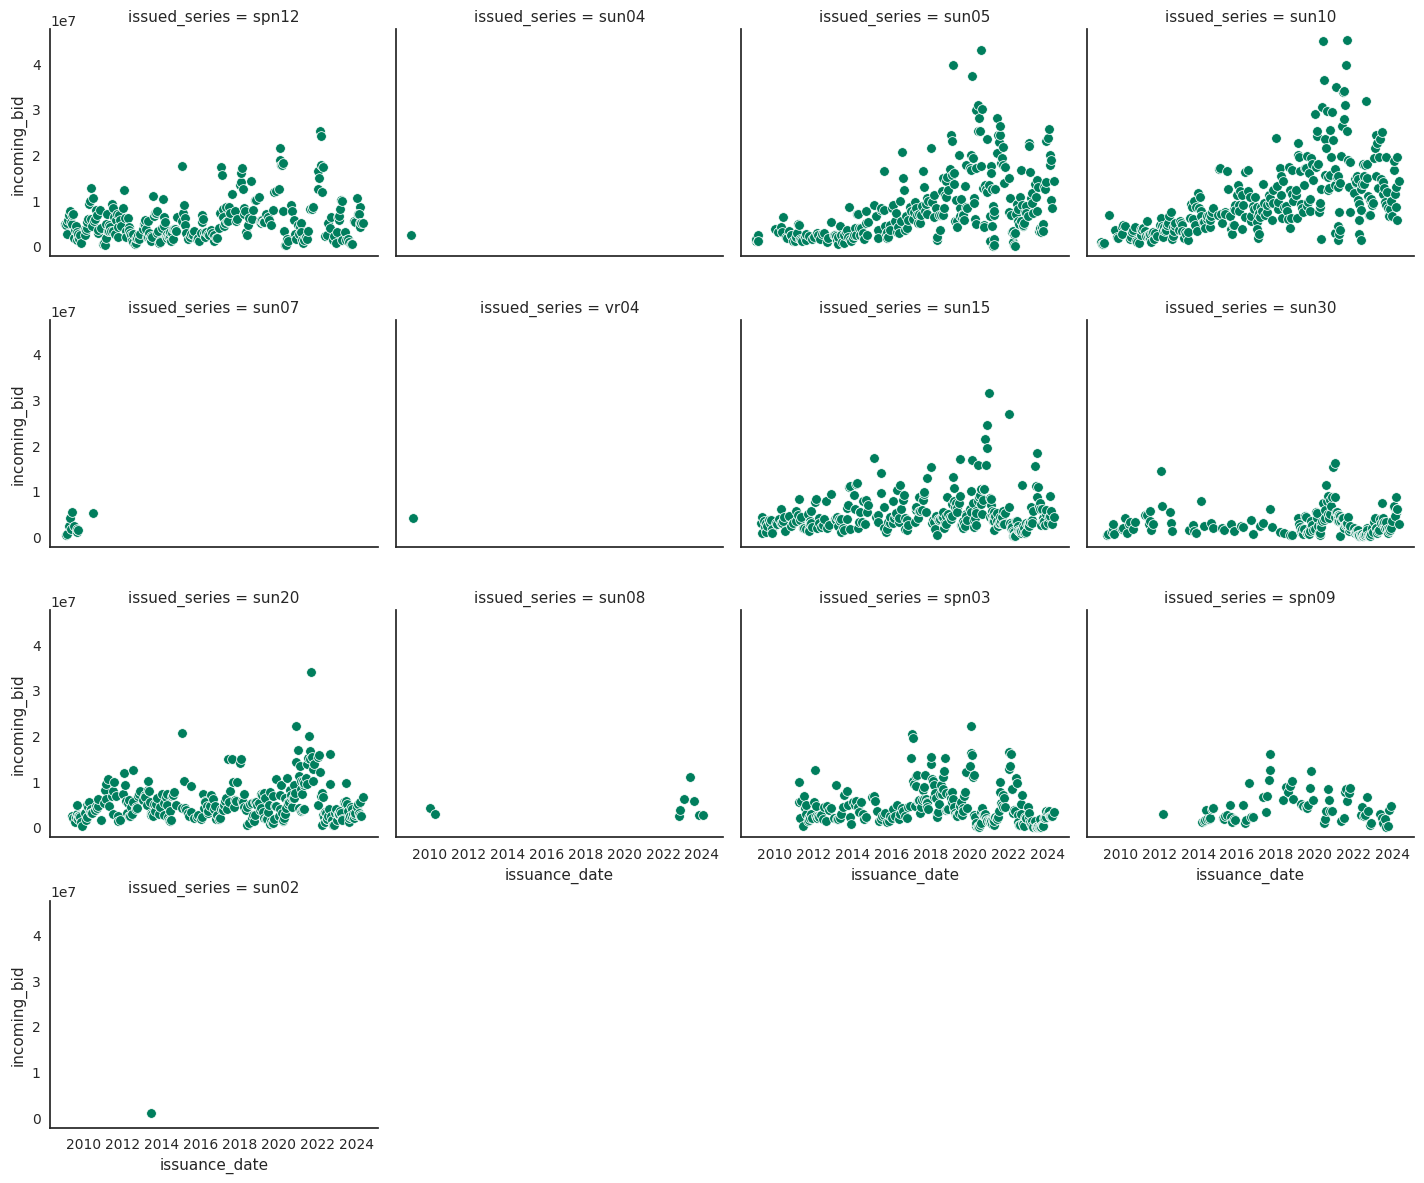

In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt

sns.set_style("white")

# Create a FacetGrid and use map to create subplots based on 'FacetVar'
ch01 = sns.FacetGrid(df_train00, col='issued_series', col_wrap=4, height=3, aspect=1.2)
ch01.map(sns.scatterplot, 'issuance_date', 'incoming_bid', color='#007e5d')

# Show the plot
# plt.show()


In [ ]:
# corr_matrix = df_train00.corr()
# corr_matrix['incoming_bid'].sort_values(ascending=False)

ValueError: could not convert string to float: 'spn12'

In [ ]:
df_train01 = df_train00[~df_train00['issued_series'].isin(['sun04', 'sun02', 'vr04', 'spn09', 'sun07'])]

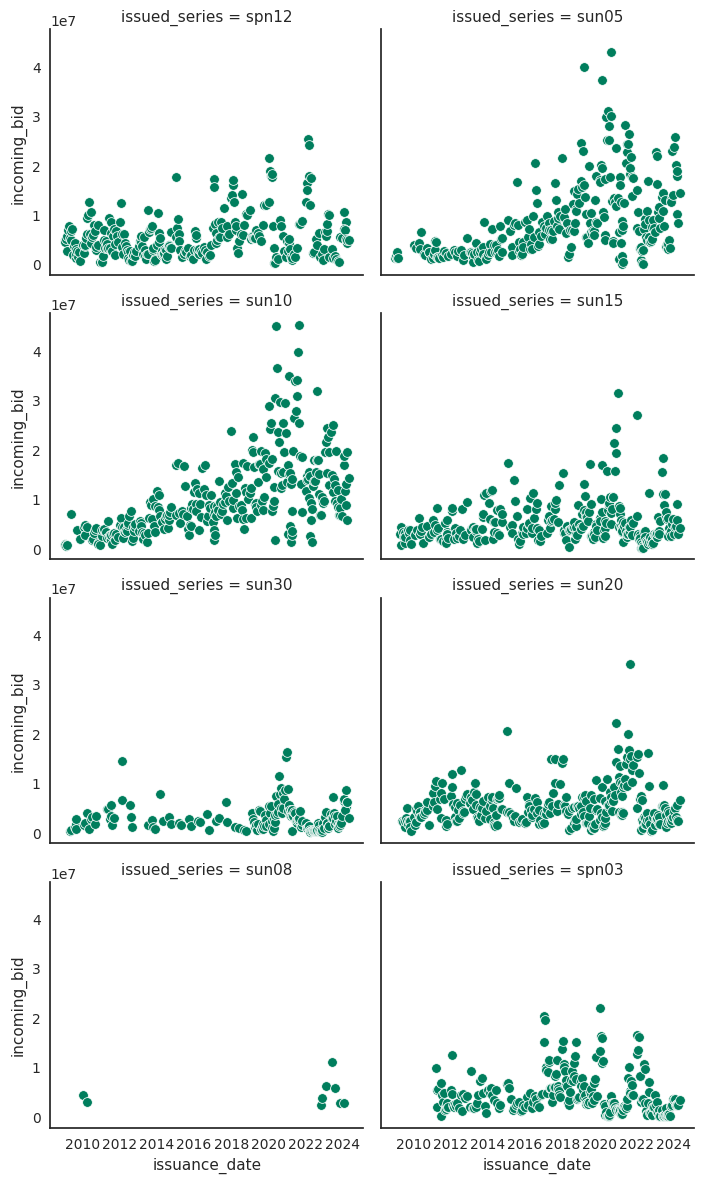

In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt

sns.set_style("white")

# Create a FacetGrid and use map to create subplots based on 'FacetVar'
ch02 = sns.FacetGrid(df_train01, col='issued_series', col_wrap=2, height=3, aspect=1.2)
ch02.map(sns.scatterplot, 'issuance_date', 'incoming_bid', color='#007e5d')

# Show the plot
# plt.show()


In [ ]:
# Get the order of categories
issd_series = df_train01['issued_series'].unique()

# Sort the order
issd_series.sort()

# Create a boxplot with sorted order
# sns.boxplot(x='issued_series', y='incoming_bid', data=df_train01,
#             order=issd_series, hue='issuance_year')

# sns.boxplot(x='issued_series', y='incoming_bid', data=df_train01,
#             order=issd_series)
# plt.show()

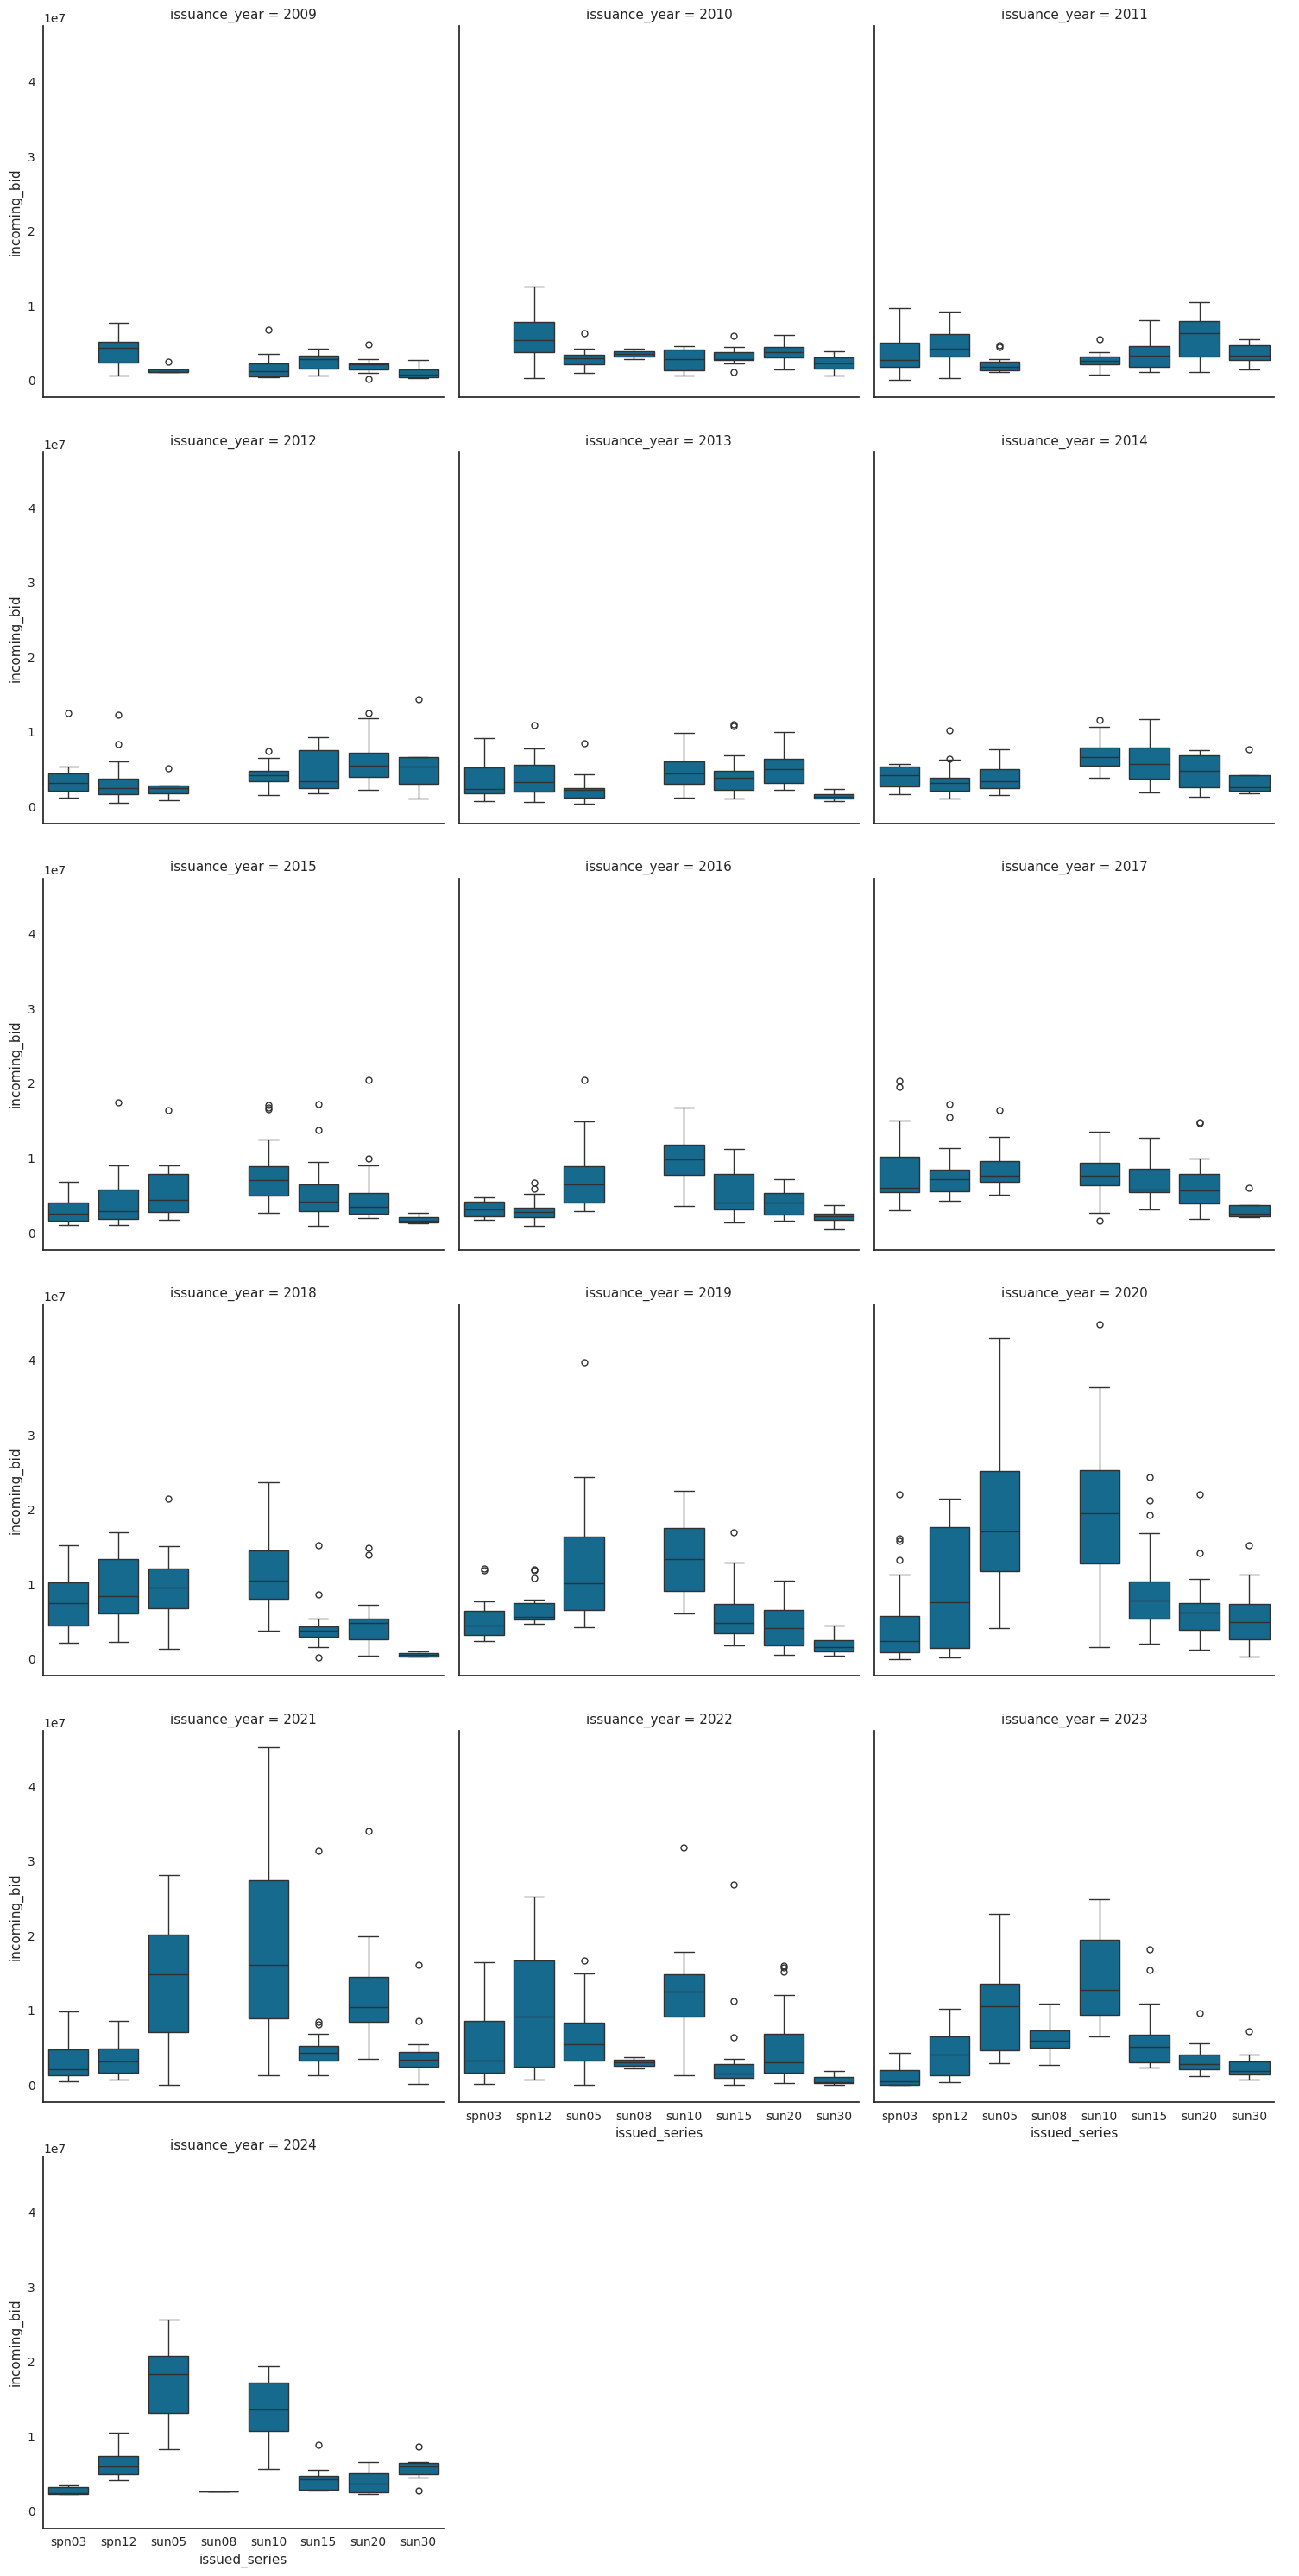

In [ ]:
sns.catplot(x='issued_series', y='incoming_bid', data=df_train01,
                order=issd_series, kind='box', col='issuance_year', col_wrap=3)

### Split: Biased

In [ ]:
# df_train02 = df_train01.sample(frac=0.9, random_state=786)
# df_unseen01 = df_train01.drop(df_train02.index)

# df_train02.reset_index(drop=True, inplace=True)
# df_unseen01.reset_index(drop=True, inplace=True)

# print('Data for Modeling: ' + str(df_train02.shape))
# print('Unseen Data For Predictions: ' + str(df_unseen01.shape))

In [ ]:
# print("Train: \n{} \n\nTest: \n{}".format(df_train02['issued_series'].value_counts(), df_unseen01['issued_series'].value_counts()))

### Split: Stratified

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

# Assuming df is your DataFrame and 'target_column' is the target variable
split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)

for train_index, test_index in split.split(df_train01, df_train01['issued_series']):
    # Explicitly reset the index
    df_train02 = df_train01.iloc[train_index]
    df_unseen01 = df_train01.iloc[test_index]

# Explicitly reset the index for df_train02 and df_test01
# df_train02 = df_train02.reset_index(drop=True)
# df_unseen01 = df_unseen01.reset_index(drop=True)

# Display the shapes of the resulting sets (optional)
print("Train set shape:", df_train02.shape)
print("Test set shape:", df_unseen01.shape)

Train set shape: (1669, 12)
Test set shape: (186, 12)


In [ ]:
print("Train: \n{} \n\nTest: \n{}".format(df_train02['issued_series'].value_counts(), df_unseen01['issued_series'].value_counts()))

Train: 
issued_series
sun10    269
sun20    265
spn12    251
sun15    251
sun05    246
spn03    220
sun30    159
sun08      8
Name: count, dtype: int64 

Test: 
issued_series
sun10    30
sun20    29
spn12    28
sun15    28
sun05    27
spn03    25
sun30    18
sun08     1
Name: count, dtype: int64


In [ ]:
# Identifying duplicates
duplicates = df_train02[df_train02.index.duplicated()]
print("Rows with duplicate indices:")
print(duplicates)


Rows with duplicate indices:
Empty DataFrame
Columns: [issued_series, issuance_date, issuance_year, issuance_week, monthfrac, eid_weeks, srbi_issuance, vix_indicator, bi_covid, gso_issuance, investment_grade, incoming_bid]
Index: []


In [ ]:
# Identifying duplicates
duplicates = df_unseen01[df_unseen01.index.duplicated()]
print("Rows with duplicate indices:")
print(duplicates)

Rows with duplicate indices:
Empty DataFrame
Columns: [issued_series, issuance_date, issuance_year, issuance_week, monthfrac, eid_weeks, srbi_issuance, vix_indicator, bi_covid, gso_issuance, investment_grade, incoming_bid]
Index: []


# Methods

## Setup

In [ ]:
session01 = setup(data=df_train02, target='incoming_bid', session_id=123,
                  test_data=df_unseen01,
                  categorical_features=['issued_series'],
                  ignore_features = ['issuance_date'])

,Description,Value
0,Session id,123
1,Target,incoming_bid
2,Target type,Regression
3,Original data shape,"(1855, 12)"
4,Transformed data shape,"(1855, 18)"
5,Transformed train set shape,"(1669, 18)"
6,Transformed test set shape,"(186, 18)"
7,Ignore features,1
8,Numeric features,9
9,Categorical features,1


## Compare Models

In [ ]:
best01 = compare_models(sort = 'rmse')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
xgboost,Extreme Gradient Boosting,2377393.6250,12587395186688.0000,3527355.1500,0.6560,1.2164,0.9935,0.1930
et,Extra Trees Regressor,2364220.0453,12737603502063.6289,3544167.1221,0.6529,1.1190,0.8298,0.4220
rf,Random Forest Regressor,2421738.3380,12959820950841.6309,3579602.0446,0.6457,1.2137,1.0072,0.8580
lightgbm,Light Gradient Boosting Machine,2439208.3105,13030686413371.9785,3585380.2347,0.6456,1.2362,1.0071,0.9630
gbr,Gradient Boosting Regressor,2932401.3227,18090764882565.0703,4224816.8230,0.5069,1.3100,1.4287,0.1860
knn,K Neighbors Regressor,3127214.9000,20320679991705.6016,4499089.5000,0.4336,1.3606,1.8706,0.0680
dt,Decision Tree Regressor,3058531.4451,22498680889326.8359,4727497.3626,0.3635,1.3130,0.9762,0.0660
ridge,Ridge Regression,3680537.3710,26632994970046.7383,5140421.6386,0.2687,1.5093,2.4243,0.0670
lasso,Lasso Regression,3686066.9066,26631243001596.8359,5141033.6635,0.2683,1.5111,2.4208,0.1360
llar,Lasso Least Angle Regression,3686703.4165,26633450111011.7734,5141324.5833,0.2682,1.5083,2.4208,0.0670


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

## Features

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2428026.6147,12048923453289.0117,3471155.9247,0.6671,1.3575,0.9966
1,2228132.6764,8950024966624.3906,2991659.2330,0.6600,1.7415,1.6831
2,2583125.8035,16748469016325.8340,4092489.3422,0.5678,1.3944,1.8923
3,2307012.2118,10314157879645.6699,3211566.2658,0.6675,0.6810,0.8626
4,2442237.8426,11768826021681.6055,3430572.2586,0.6784,1.5157,0.7186
5,2611303.7141,14971171599573.5039,3869259.8258,0.5857,1.2820,0.6594
6,2558840.7133,15620763532200.9062,3952311.1634,0.6661,0.8911,1.1985
7,2253251.4155,10178779885955.2812,3190420.0172,0.6921,1.1792,0.6387
8,2509474.9761,18627227248946.4922,4315927.1598,0.6355,0.6457,0.7049


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

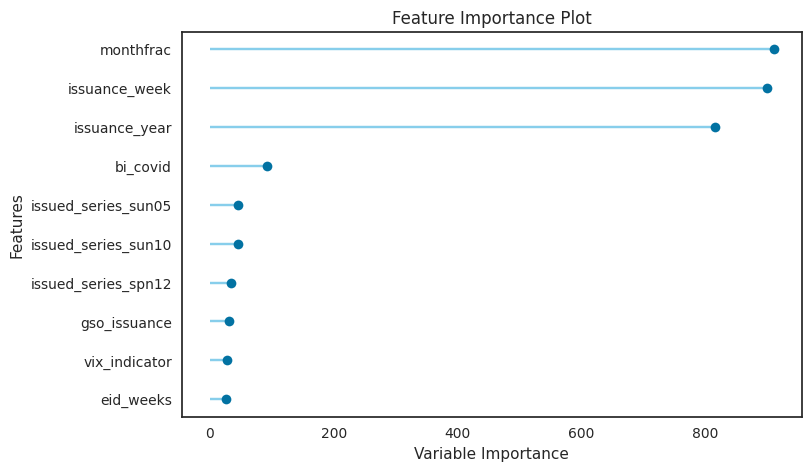

In [ ]:
plot_model(create_model('lightgbm'), plot='feature')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2260380.2500,10543950725120.0000,3247145.0000,0.7086,1.4000,0.9596
1,2267943.5000,10243802136576.0000,3200594.0000,0.6109,1.6947,3.2024
2,2353946.0000,12807089160192.0000,3578699.2500,0.6695,1.4298,1.0635
3,2350545.2500,12333836402688.0000,3511956.2500,0.6023,0.7051,0.8349
4,2357522.2500,11585993048064.0000,3403820.2500,0.6834,1.5035,0.6339
5,2527201.2500,14064106340352.0000,3750214.2500,0.6108,1.2754,0.5864
6,2522129.7500,16146222809088.0000,4018236.2500,0.6549,0.6460,0.7309
7,2231228.5000,9725242507264.0000,3118532.0000,0.7058,1.1390,0.5923
8,2583993.0000,18661387534336.0000,4319883.0000,0.6348,0.7222,0.6823


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

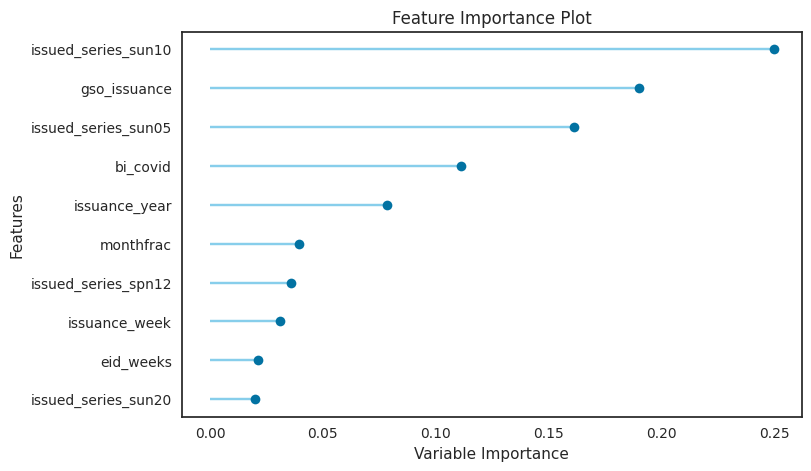

In [ ]:
plot_model(create_model('xgboost'), plot='feature')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2179001.7545,10590975529482.4141,3254377.9021,0.7073,1.2391,0.8343
1,2163756.6946,10115655490920.6699,3180511.8285,0.6158,1.4262,1.1730
2,2525630.5629,14382920968941.7129,3792482.1646,0.6288,1.1392,2.0699
3,2372406.5569,13149541343217.5391,3626229.6319,0.5760,0.6637,0.7256
4,2379654.3832,11500383466539.0391,3391221.5301,0.6857,1.6347,0.5990
5,2321530.3293,11326408062144.4727,3365472.9329,0.6865,1.2500,0.5245
6,2656545.5838,17685804301860.1094,4205449.3579,0.6220,0.6027,0.6565
7,2107875.6647,9444472615343.3652,3073186.0691,0.7143,1.0265,0.4803
8,2645971.7275,18921859146115.8438,4349926.3380,0.6297,0.5994,0.6250


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

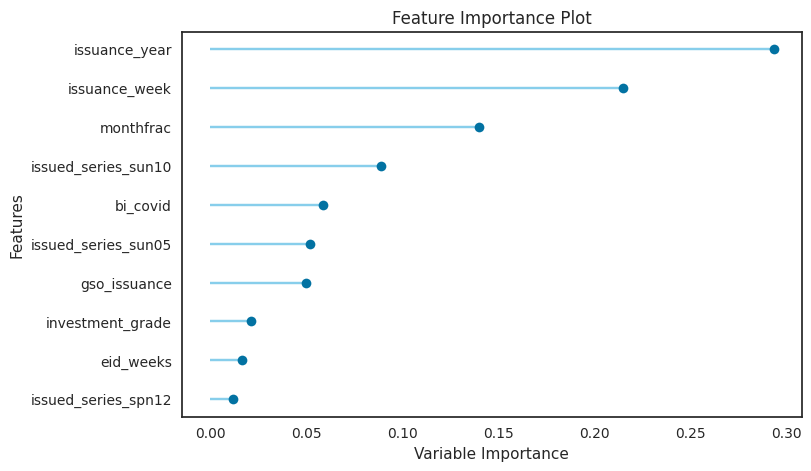

In [ ]:
plot_model(create_model('et'), plot='feature')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2142659.7968,10515343846173.8359,3242737.0917,0.7094,1.2650,0.8070
1,2285139.3179,9556991202415.1348,3091438.3711,0.6370,1.7322,2.3934
2,2680920.5117,16860772547737.8809,4106187.1058,0.5649,1.3278,1.9672
3,2320322.6543,10744225546367.2793,3277838.5479,0.6536,0.6858,0.8552
4,2451696.4051,11922528971380.9863,3452901.5293,0.6742,1.6626,0.6489
5,2419915.6499,12371378526962.0703,3517297.0484,0.6576,1.2773,0.6015
6,2545515.7825,15433739539206.8105,3928579.8374,0.6701,0.6551,0.7821
7,2253422.9670,11232711555041.8359,3351523.7661,0.6602,1.2040,0.5840
8,2569053.0573,18638084491437.8672,4317184.7877,0.6353,0.6032,0.6591


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

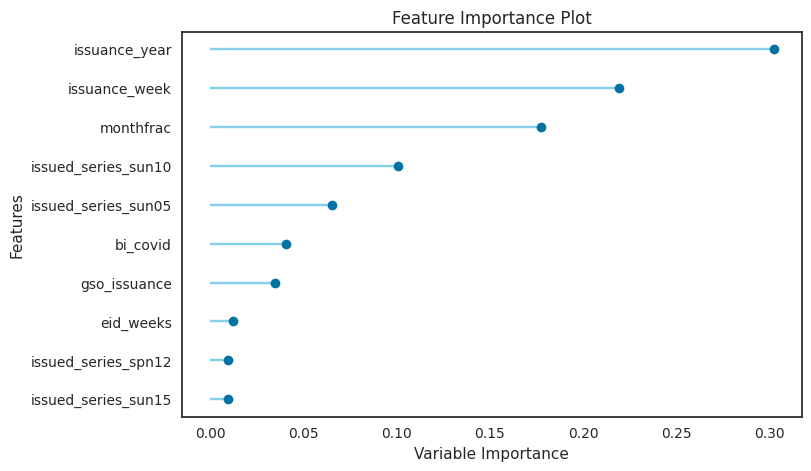

In [ ]:
plot_model(create_model('rf'), plot='feature')

# Algorithms

## Light Gradient Boosting Machine

### Raw -- 64.56%

In [ ]:
# train a xgb model with default params
lightgbm_raw = create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2428026.6147,12048923453289.0117,3471155.9247,0.6671,1.3575,0.9966
1,2228132.6764,8950024966624.3906,2991659.2330,0.6600,1.7415,1.6831
2,2583125.8035,16748469016325.8340,4092489.3422,0.5678,1.3944,1.8923
3,2307012.2118,10314157879645.6699,3211566.2658,0.6675,0.6810,0.8626
4,2442237.8426,11768826021681.6055,3430572.2586,0.6784,1.5157,0.7186
5,2611303.7141,14971171599573.5039,3869259.8258,0.5857,1.2820,0.6594
6,2558840.7133,15620763532200.9062,3952311.1634,0.6661,0.8911,1.1985
7,2253251.4155,10178779885955.2812,3190420.0172,0.6921,1.1792,0.6387
8,2509474.9761,18627227248946.4922,4315927.1598,0.6355,0.6457,0.7049


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

### Tuning -- 58.62%

In [ ]:
# tune hyperparameters of lightgbm
lightgbm_tuned = tune_model(lightgbm_raw)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2609669.7398,13833119362940.3828,3719290.1692,0.6178,1.3595,1.0684
1,2509177.4783,11341133059939.1660,3367659.8789,0.5692,1.8283,1.0157
2,2832647.6324,18098753459989.0312,4254262.9749,0.5330,1.5890,4.1869
3,2691738.0469,13897012258807.1309,3727869.6676,0.5519,0.8974,1.0554
4,2714353.5097,14396198491307.7598,3794232.2664,0.6066,1.5818,0.7568
5,2694367.6176,14308064929811.7246,3782600.2868,0.6040,1.3317,0.6278
6,2631797.3435,15262847481383.6504,3906769.4431,0.6738,0.8195,0.7668
7,2609956.9647,13715521551909.0742,3703447.2525,0.5851,1.2624,0.6812
8,2798350.7282,20515056555350.0391,4529354.9823,0.5985,0.6868,0.7866


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


### Modifying -- 67.30%

In [ ]:

# Define a more comprehensive tuning grid for LightGBM
lightgbm_grid = {
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3, 0.5],
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7, 9, 11],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 0.01, 0.001],
    'reg_lambda': [1, 1.5, 2, 3, 4],
    'num_leaves': [15, 31, 63, 127],
    'min_split_gain': [0, 0.1, 0.2, 0.3, 0.4],
    'subsample_freq': [0, 1, 2],
}

# Tune LightGBM model with custom grid and optimize for R2
lightgbm_modified = tune_model(lightgbm_raw, custom_grid=lightgbm_grid, optimize='mse', early_stopping=True, choose_better=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2311345.1412,10513455338611.7480,3242445.8883,0.7095,1.2879,1.0312
1,2212275.0860,9037456622115.3242,3006236.2885,0.6567,1.7303,2.0929
2,2501160.9142,15094350665937.4336,3885144.8706,0.6105,1.3874,1.2355
3,2196189.9266,10039449902876.6191,3168509.0978,0.6763,0.7153,0.8865
4,2472734.5365,11935204636162.1465,3454736.5509,0.6738,1.6315,0.7142
5,2374383.9475,12405951437159.0352,3522208.3183,0.6567,1.2554,0.5796
6,2647936.6702,14807390704836.6328,3848037.2536,0.6835,0.8564,0.9673
7,2193620.8822,8998639866245.2578,2999773.3025,0.7278,1.2721,0.5718
8,2506678.0253,16996480019010.1309,4122678.7431,0.6674,0.6160,0.6469


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


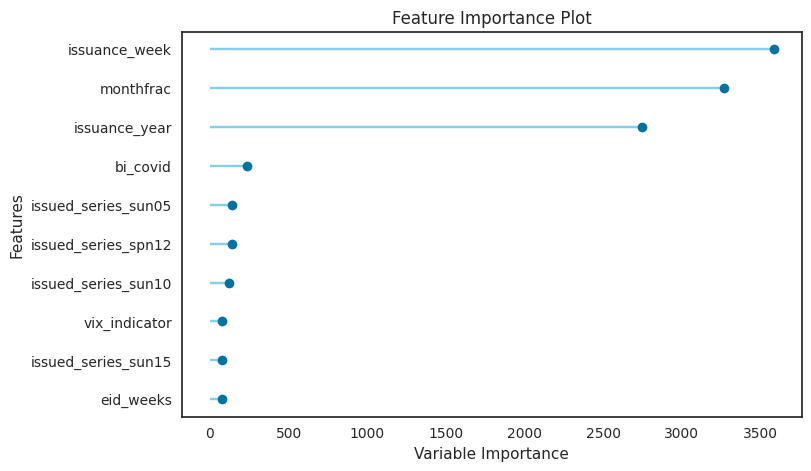

In [ ]:
plot_model(lightgbm_modified, plot = 'feature')

### Bagging -- 64.10%

In [ ]:
# ensemble with bagging
lightgbm_bagged = ensemble_model(lightgbm_raw, method = 'Bagging')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2452614.2307,12111496682244.1289,3480157.5657,0.6653,1.3266,0.9486
1,2285077.8875,9218829844432.5156,3036252.5989,0.6498,1.7103,1.5828
2,2642210.2521,16888807763977.9453,4109599.4652,0.5642,1.4289,1.4427
3,2464147.7785,11303148623106.7070,3362015.5596,0.6356,0.7238,0.9690
4,2401627.9900,11705568962528.4980,3421340.2290,0.6801,1.4734,0.6968
5,2546529.1046,15276473046672.2168,3908512.8945,0.5772,1.2939,0.6369
6,2578606.7486,16038071011754.5508,4004756.0490,0.6572,0.7254,1.1148
7,2193691.7923,9833662712328.3867,3135867.1388,0.7026,1.1458,0.6117
8,2604991.2400,19203045174974.5195,4382127.9277,0.6242,0.6420,0.7273


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

### Boosting -- 64.65%

In [ ]:
# ensemble with boosting
lightgbm_boosted = ensemble_model(lightgbm_raw, method = 'Boosting')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2599751.1747,12800832882847.8203,3577825.1610,0.6463,1.3993,1.1426
1,2294534.0509,9126530584662.0625,3021014.8270,0.6533,1.7248,2.0785
2,2611297.8098,15978102811419.9355,3997261.9143,0.5877,1.4272,1.2416
3,2495728.8652,11366358070555.3398,3371402.9825,0.6335,0.7162,0.9567
4,2448113.5921,12539169962868.1973,3541069.0424,0.6573,1.5397,0.7707
5,2461550.4846,12552425079194.6641,3542940.1744,0.6526,1.3400,0.6255
6,2694304.0847,15990372633154.6758,3998796.3981,0.6582,0.7818,1.2190
7,2264894.8116,9848670621671.6758,3138259.1706,0.7021,0.8729,0.6235
8,2632473.4298,19576273292563.3555,4424508.2543,0.6169,0.6320,0.7549


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

## Extreme Gradient Boosting

### Raw -- 65.60%

In [ ]:
# train a xgb model with default params
xgb_raw = create_model('xgboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2260380.2500,10543950725120.0000,3247145.0000,0.7086,1.4000,0.9596
1,2267943.5000,10243802136576.0000,3200594.0000,0.6109,1.6947,3.2024
2,2353946.0000,12807089160192.0000,3578699.2500,0.6695,1.4298,1.0635
3,2350545.2500,12333836402688.0000,3511956.2500,0.6023,0.7051,0.8349
4,2357522.2500,11585993048064.0000,3403820.2500,0.6834,1.5035,0.6339
5,2527201.2500,14064106340352.0000,3750214.2500,0.6108,1.2754,0.5864
6,2522129.7500,16146222809088.0000,4018236.2500,0.6549,0.6460,0.7309
7,2231228.5000,9725242507264.0000,3118532.0000,0.7058,1.1390,0.5923
8,2583993.0000,18661387534336.0000,4319883.0000,0.6348,0.7222,0.6823


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

### Tuning -- 65.95%

In [ ]:
# tune hyperparameters of xgb
xgb_tuned = tune_model(xgb_raw)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2448750.7500,12712852586496.0000,3565508.7500,0.6487,1.3100,0.9008
1,2208350.0000,8845695909888.0000,2974171.5000,0.6640,1.8136,3.2780
2,2495705.2500,14499870408704.0000,3807869.5000,0.6258,1.3617,1.2590
3,2335488.5000,10991530147840.0000,3315347.7500,0.6456,0.7404,0.8378
4,2423959.7500,11517409886208.0000,3393731.0000,0.6853,1.6086,0.6313
5,2364503.5000,11209874079744.0000,3348115.0000,0.6898,1.2002,0.5733
6,2574148.5000,15143710752768.0000,3891492.0000,0.6763,0.8198,0.7407
7,2228022.7500,10667144773632.0000,3266059.5000,0.6774,1.1977,0.5606
8,2522895.7500,17276068691968.0000,4156449.0000,0.6619,0.6655,0.6955


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


### Modifying -- 66.83%

In [ ]:
# define a more comprehensive tuning grid for XGBoost
xgb_grid = {
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3, 0.5],
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7, 9, 11],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'reg_alpha': [0, 0.1, 0.01, 0.001],
    'reg_lambda': [1, 1.5, 2, 3, 4]
}

# tune model with custom grid and optimize for R2
xgb_modified = tune_model(xgb_raw, custom_grid=xgb_grid, optimize='mse', early_stopping=True, choose_better=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2392978.5000,11454348525568.0000,3384427.2500,0.6835,1.2714,0.9796
1,2159580.0000,8409253412864.0000,2899871.2500,0.6806,1.7220,2.3130
2,2449559.0000,15264377733120.0000,3906965.2500,0.6061,1.3892,1.2518
3,2331206.2500,10822861455360.0000,3289811.7500,0.6511,0.6792,0.8487
4,2463375.0000,11494083264512.0000,3390292.5000,0.6859,1.5993,0.6706
5,2446807.7500,12617681731584.0000,3552137.7500,0.6508,1.2169,0.5668
6,2571550.2500,14979476488192.0000,3870332.7500,0.6798,0.7222,0.8119
7,2173446.5000,9026287960064.0000,3004378.2500,0.7270,0.9551,0.5816
8,2547340.2500,17760855785472.0000,4214363.0000,0.6524,0.6394,0.7414


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


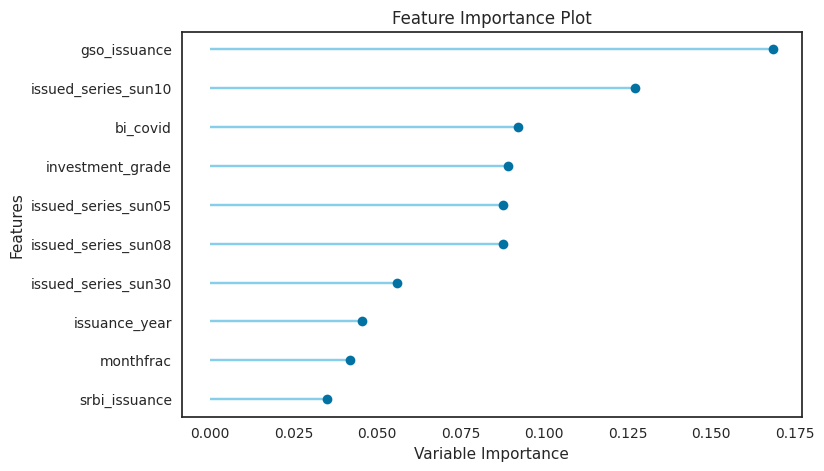

In [ ]:
plot_model(xgb_modified, plot = 'feature')

### Bagging -- 66.28%

In [ ]:
# ensemble with bagging
xgb_bagged = ensemble_model(xgb_raw, method = 'Bagging')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2333337.0000,11426263465984.0000,3380275.7500,0.6843,1.3347,0.8643
1,2240565.7500,9387781390336.0000,3063948.7500,0.6434,1.6797,2.5287
2,2506671.2500,15452472344576.0000,3930963.2500,0.6012,1.4448,1.5929
3,2375071.7500,11553821687808.0000,3399091.2500,0.6275,0.6685,0.8278
4,2356241.2500,10745695698944.0000,3278062.7500,0.7063,1.4432,0.6520
5,2405350.7500,13198537261056.0000,3632979.0000,0.6347,1.2818,0.5585
6,2546816.5000,15129312755712.0000,3889641.7500,0.6766,0.6138,0.6528
7,2157550.2500,9785614270464.0000,3128196.7500,0.7040,1.1974,0.6061
8,2518697.7500,17694657085440.0000,4206502.0000,0.6537,0.6258,0.7452


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

### Boosting -- 66.29%

In [ ]:
# ensemble with boosting
xgb_boosted = ensemble_model(xgb_raw, method = 'Boosting')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2373753.2500,11440503128064.0000,3382381.2500,0.6839,1.3744,0.9276
1,2146335.7500,8636544319488.0000,2938799.7500,0.6720,1.7474,3.2140
2,2433392.2500,14274473754624.0000,3778157.5000,0.6316,1.4366,2.5800
3,2255326.5000,10797449216000.0000,3285947.2500,0.6519,0.6258,0.7391
4,2280589.7500,10328760909824.0000,3213839.0000,0.7177,1.5790,0.6299
5,2447905.7500,12959941132288.0000,3599991.7500,0.6413,1.2535,0.5633
6,2650218.0000,17672685223936.0000,4203889.5000,0.6223,0.6340,0.6590
7,2263568.5000,10716144730112.0000,3273552.2500,0.6759,1.0426,0.6253
8,2602561.7500,18697555017728.0000,4324067.0000,0.6341,0.6310,0.7387


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

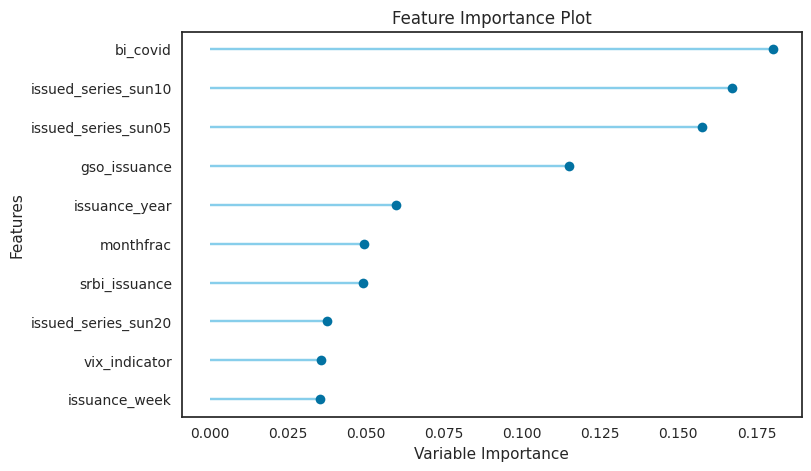

In [ ]:
plot_model(xgb_boosted, plot = 'feature')

## Extra Trees Regressor

### Raw -- 65.29%

In [ ]:
# train a et model with default params
et_raw = create_model('et')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2179001.7545,10590975529482.4141,3254377.9021,0.7073,1.2391,0.8343
1,2163756.6946,10115655490920.6699,3180511.8285,0.6158,1.4262,1.1730
2,2525630.5629,14382920968941.7129,3792482.1646,0.6288,1.1392,2.0699
3,2372406.5569,13149541343217.5391,3626229.6319,0.5760,0.6637,0.7256
4,2379654.3832,11500383466539.0391,3391221.5301,0.6857,1.6347,0.5990
5,2321530.3293,11326408062144.4727,3365472.9329,0.6865,1.2500,0.5245
6,2656545.5838,17685804301860.1094,4205449.3579,0.6220,0.6027,0.6565
7,2107875.6647,9444472615343.3652,3073186.0691,0.7143,1.0265,0.4803
8,2645971.7275,18921859146115.8438,4349926.3380,0.6297,0.5994,0.6250


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

### Tuning -- 53.64%

In [ ]:
# tune hyperparameters of et
et_tuned = tune_model(et_raw)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2909163.8800,16520667831790.0293,4064562.4404,0.5435,1.3769,1.1273
1,2700980.6825,13115978298021.9766,3621598.8593,0.5018,1.7986,2.4278
2,2982340.0211,21459610837218.9688,4632451.9250,0.4462,1.5047,4.4007
3,2882890.6817,15257714273218.5723,3906112.4245,0.5081,0.8280,1.2462
4,2694550.1294,13706415466352.0605,3702217.6417,0.6254,1.7584,0.8615
5,2783523.6957,18631889436772.1953,4316467.2403,0.4843,1.3293,0.7246
6,2877643.1798,18575814252841.9883,4309966.8506,0.6030,0.7581,1.0852
7,2513502.4901,14297862620527.9902,3781251.4622,0.5675,1.3134,0.7728
8,3135551.1300,24640053621091.8633,4963874.8595,0.5178,0.7572,1.0560


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


### Modifying -- 60.80%

In [ ]:
# define a more comprehensive tuning grid for Random Forest Regressor
et_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 4, 8, 12],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['auto', 'sqrt', None],
    'bootstrap': [True, False]
}

# Tune model with the optimized grid and optimize for Mean Squared Error (mse)
et_modified = tune_model(et_raw, custom_grid=et_grid, optimize='mse', early_stopping=True, choose_better=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2524263.9295,13020602792391.8359,3608407.2376,0.6402,1.2876,0.9870
1,2486427.5590,11383284511222.1113,3373912.3449,0.5676,1.6945,2.0885
2,2720180.3176,19260318571848.2852,4388657.9466,0.5030,1.4213,2.4944
3,2584370.1997,12707294766953.4336,3564729.2698,0.5903,0.7816,1.1140
4,2501081.6082,11161410429658.9551,3340869.7116,0.6950,1.6989,0.7525
5,2469764.6842,15209743989768.7734,3899967.1780,0.5791,1.2797,0.6519
6,2626264.5506,17399685425250.7559,4171293.0160,0.6281,0.7175,1.1085
7,2310674.6375,11050896364548.8828,3324288.8509,0.6657,1.2407,0.6926
8,2916966.5366,21886992062166.0234,4678353.5632,0.5717,0.7110,0.9329


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


### Bagging -- 64.28%

In [ ]:
# ensemble with bagging
et_bagged = ensemble_model(et_raw, method = 'Bagging')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2286237.3633,11314896152569.2754,3363762.2021,0.6873,1.1998,0.8366
1,2296770.4634,10644172907650.4844,3262540.8668,0.5957,1.6388,2.3193
2,2676958.6912,16857795794078.0605,4105824.6180,0.5650,1.2804,2.0361
3,2364378.2276,11971735075121.5117,3460019.5195,0.6140,0.6934,0.8670
4,2366533.9108,11309116857747.8613,3362903.0402,0.6910,1.6307,0.6288
5,2335050.1840,13884139875015.0410,3726142.7610,0.6157,1.2262,0.5513
6,2659242.6853,17949922179282.6016,4236734.8488,0.6164,0.6457,0.7627
7,2051253.3567,8888629024322.0938,2981380.3891,0.7311,1.1482,0.5113
8,2627832.9878,18310979523270.9531,4279133.0341,0.6417,0.6347,0.7220


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

### Boosting -- 66.15%

In [ ]:
# ensemble with boosting
et_boosted = ensemble_model(et_raw, method = 'Boosting')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2221355.2455,11109318076312.3945,3333064.3673,0.6930,1.2213,0.8305
1,2159102.0240,9814928924663.3379,3132878.6961,0.6272,1.6091,1.6586
2,2473550.0168,13780629282256.6289,3712226.9977,0.6444,1.3057,1.6813
3,2304974.5659,12131169666224.7266,3482982.8691,0.6089,0.6691,0.7961
4,2375644.7071,11324634232026.5996,3365209.3890,0.6905,1.6176,0.5964
5,2344363.5311,11113951259353.8047,3333759.3283,0.6924,1.2030,0.5917
6,2670974.2934,17810145779197.4062,4220206.8408,0.6193,0.6391,0.7605
7,2034889.9189,8548988234003.1797,2923865.2900,0.7414,1.1496,0.5240
8,2666456.8204,18911975072086.9414,4348790.0699,0.6299,0.6308,0.7128


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

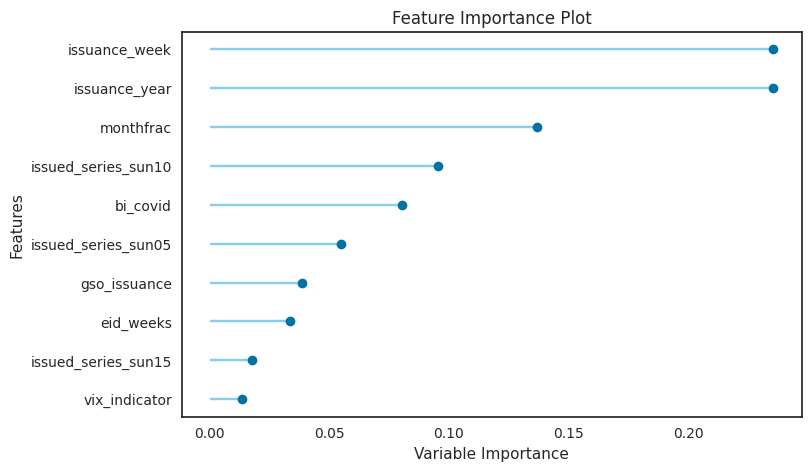

In [ ]:
plot_model(et_boosted, plot = 'feature')

## Random Forest Regressor

### Raw -- 64.57%

In [ ]:
# train a rf model with default params
rf_raw = create_model('rf')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2142659.7968,10515343846173.8359,3242737.0917,0.7094,1.2650,0.8070
1,2285139.3179,9556991202415.1348,3091438.3711,0.6370,1.7322,2.3934
2,2680920.5117,16860772547737.8809,4106187.1058,0.5649,1.3278,1.9672
3,2320322.6543,10744225546367.2793,3277838.5479,0.6536,0.6858,0.8552
4,2451696.4051,11922528971380.9863,3452901.5293,0.6742,1.6626,0.6489
5,2419915.6499,12371378526962.0703,3517297.0484,0.6576,1.2773,0.6015
6,2545515.7825,15433739539206.8105,3928579.8374,0.6701,0.6551,0.7821
7,2253422.9670,11232711555041.8359,3351523.7661,0.6602,1.2040,0.5840
8,2569053.0573,18638084491437.8672,4317184.7877,0.6353,0.6032,0.6591


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

### Tuning -- 57.13%

In [ ]:
# tune hyperparameters of rf
rf_tuned = tune_model(rf_raw)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2665181.3001,14553909173885.8086,3814958.6071,0.5978,1.3697,1.0981
1,2581619.6301,11463604794480.3359,3385794.5588,0.5646,1.8104,2.7035
2,2866427.8097,19478847122662.0469,4413484.6916,0.4973,1.5072,3.4613
3,2693485.7625,12952649811704.4121,3598978.9957,0.5824,0.7930,1.1717
4,2546613.7293,12633187364485.2715,3554319.5361,0.6548,1.7402,0.7851
5,2687883.8940,16516622901070.0000,4064064.8249,0.5429,1.3509,0.6975
6,2724615.0456,17148393095183.1270,4141061.8318,0.6335,0.7294,0.9926
7,2500533.2571,14320147076671.5352,3784197.0187,0.5669,1.2738,0.7066
8,2931661.0788,22816357569348.9609,4776647.1054,0.5535,0.7165,0.9479


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


### Modifying -- 63.61%

In [ ]:
# define a more comprehensive tuning grid for Random Forest Regressor
rf_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 4, 8, 12, 16],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2', None],
    'bootstrap': [True, False]
}

# Tune model with the optimized grid and optimize for Mean Squared Error (mse)
rf_modified = tune_model(rf_raw, custom_grid=rf_grid, optimize='mse', early_stopping=True, choose_better=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2232884.8956,11017310072311.6641,3319233.3561,0.6956,1.2902,0.8385
1,2312070.3203,9794287392139.6523,3129582.6227,0.6280,1.7464,2.6349
2,2698385.4560,17380807404012.7812,4169029.5518,0.5515,1.3642,1.8995
3,2400950.7784,11332458409804.9512,3366371.6981,0.6346,0.7103,0.9116
4,2387886.7805,11233958848536.5488,3351709.8396,0.6930,1.6649,0.6777
5,2424015.6311,12778581420073.6914,3574714.1732,0.6463,1.2805,0.6098
6,2588341.0289,15798755093451.2676,3974764.7847,0.6623,0.6642,0.8014
7,2320720.3165,11623603264948.4199,3409340.5909,0.6484,1.2321,0.6191
8,2607492.5435,19610365148693.0977,4428359.1937,0.6162,0.6264,0.7065


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


### Bagging -- 62.41%

In [ ]:
# ensemble with bagging
rf_bagged = ensemble_model(rf_raw, method = 'Bagging')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2405602.2042,12334467804811.0684,3512046.0995,0.6592,1.3157,0.9439
1,2427251.8610,10585545606952.6621,3253543.5462,0.5979,1.7776,3.1840
2,2800757.4805,18530777643292.1602,4304738.9750,0.5218,1.4143,2.3146
3,2490453.4543,11948896372114.5332,3456717.5719,0.6148,0.7375,0.9808
4,2440450.1158,11673428605180.5332,3416639.9584,0.6810,1.6802,0.7034
5,2555338.8359,14797263980456.6465,3846721.1987,0.5905,1.2820,0.6492
6,2678338.6583,16193730087264.9766,4024143.3980,0.6539,0.6971,0.9098
7,2258497.4220,10599736734834.0000,3255723.6883,0.6794,1.2388,0.6408
8,2660883.7321,19460017868130.2891,4411351.0253,0.6192,0.6577,0.8066


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

### Boosting -- 66.14%

In [ ]:
# ensemble with boosting
rf_boosted = ensemble_model(rf_raw, method = 'Boosting')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2264845.0570,10384045735902.5410,3222428.5463,0.7131,1.3370,0.9662
1,2233408.5592,8907410592596.2285,2984528.5377,0.6617,1.7415,2.6048
2,2584162.3830,15626120690403.4121,3952988.8300,0.5968,1.3719,1.7815
3,2424927.1563,11976443487788.2617,3460699.8552,0.6139,0.7235,0.9432
4,2490796.8844,12226731681110.0059,3496674.3745,0.6659,1.6704,0.7055
5,2413570.3200,11743921285270.0938,3426940.5138,0.6750,1.2759,0.6589
6,2483303.2624,13327452646501.3965,3650678.3817,0.7151,0.6735,0.9056
7,2199452.4985,10117735285285.7734,3180838.7707,0.6940,1.2195,0.6068
8,2608468.9649,19539752944908.5820,4420379.2761,0.6176,0.6549,0.7884


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

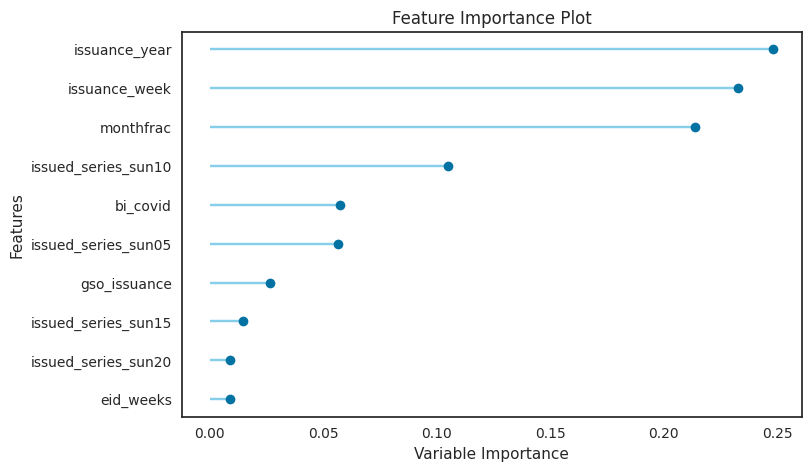

In [ ]:
plot_model(rf_boosted, plot = 'feature')

# Choosen

## Blended -- 69.52%

In [ ]:
# Blend the Boosted Ensembles
blended = blend_models(estimator_list=[lightgbm_modified, xgb_modified, et_boosted, rf_boosted], fold=10)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2147364.1136,9824834480300.0566,3134459.2006,0.7285,1.2771,0.8908
1,2095092.7144,7997473714937.8564,2827980.5012,0.6962,1.6794,2.1131
2,2433946.6781,14224903506507.5215,3771591.6410,0.6329,1.3466,1.0840
3,2212330.5281,10176009312516.3477,3189985.7856,0.6719,0.6574,0.7945
4,2355948.7957,10456869889570.7422,3233708.3804,0.7142,1.5684,0.6529
5,2281478.0465,11058669912467.1699,3325457.8501,0.6939,1.2379,0.5575
6,2463484.4274,13942277350591.6953,3733935.9061,0.7020,0.5954,0.6533
7,2024396.4033,8331718121817.8115,2886471.5695,0.7480,0.9578,0.5328
8,2468142.0111,17468574746721.6777,4179542.4088,0.6581,0.6019,0.6641


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
predict_model(blended);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,2186378.8480,10316358570789.8652,3211908.8671,0.6450,0.6066,0.6486


In [ ]:
# plot_model(blended, plot = 'residuals')

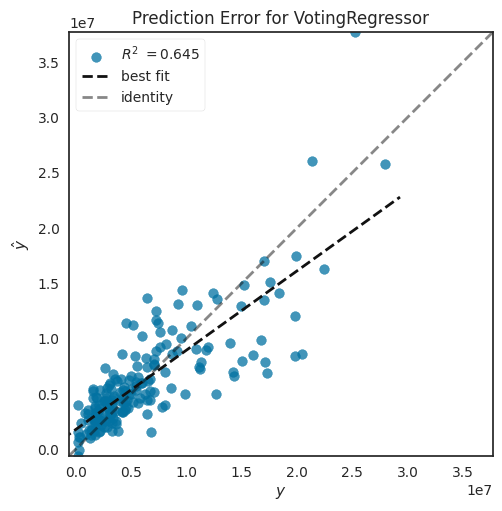

In [ ]:
plot_model(blended, plot = 'error')

## Stacked -- 69.42%

In [ ]:
stacked = stack_models(estimator_list=[lightgbm_modified, xgb_modified, et_boosted, rf_boosted])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2165822.9978,9965247205594.4453,3156777.9785,0.7246,1.2605,0.8918
1,2064839.1019,8013210143371.3652,2830761.4070,0.6956,1.6358,1.9355
2,2406053.7249,14042891690074.6016,3747384.6467,0.6376,1.3238,0.8980
3,2184509.9141,10357966071999.3496,3218379.4170,0.6661,0.6499,0.7451
4,2314397.4519,10234969667049.1367,3199213.9139,0.7203,1.4746,0.6166
5,2262148.0772,11085956927311.5488,3329558.0679,0.6932,1.1916,0.5316
6,2551468.7405,15517328663247.2188,3939204.0647,0.6683,0.6154,0.6751
7,1983311.6532,7935472741411.0332,2816997.1142,0.7600,1.0509,0.5052
8,2480482.1064,17552358010642.5664,4189553.4381,0.6565,0.5899,0.6293


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
predict_model(stacked);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Stacking Regressor,2188457.3391,10471220149871.0879,3235926.4747,0.6397,0.5782,0.6102


In [ ]:
# plot_model(stacked, plot = 'residuals')

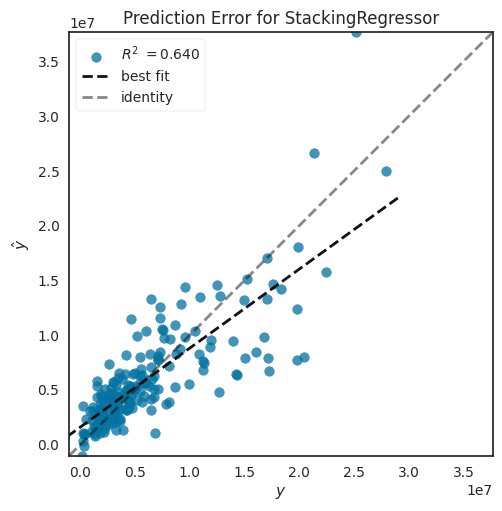

In [ ]:
plot_model(stacked, plot = 'error')

## Finalizing -- 95.82%

In [ ]:
final = finalize_model(blended)
predict_model(final);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,832688.5595,1215016450030.7268,1102277.8461,0.9582,0.2920,0.2512


In [ ]:
save_model(final, '/content/drive/MyDrive/00database/20240514_blended01')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['issuance_year', 'issuance_week',
                                              'monthfrac', 'eid_weeks',
                                              'srbi_issuance', 'vix_indicator',
                                              'bi_covid', 'gso_issuance',
                                              'investment_grade'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=['issued_series'],
                                     transformer=SimpleImpute...
                                                            n_estimators=100,
                                                            n_jobs=-1,
                                                            num_parallel_tree=None,
                                                            random_state=123,

# Lelang 14 Mei 2024

## Load

In [ ]:
lelang20240514 = pd.read_excel('/content/drive/MyDrive/00database/db_monthfrac.xlsx', sheet_name='lelang20240514')
lelang20240514['issuance_date'] = pd.to_datetime(lelang20240514['issuance_date'], format='%Y-%m-%d')
lelang20240514.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   issued_series     7 non-null      object        
 1   issuance_date     7 non-null      datetime64[ns]
 2   issuance_year     7 non-null      int64         
 3   issuance_week     7 non-null      int64         
 4   monthfrac         7 non-null      int64         
 5   eid_weeks         7 non-null      int64         
 6   srbi_issuance     7 non-null      int64         
 7   vix_indicator     7 non-null      int64         
 8   bi_covid          7 non-null      int64         
 9   gso_issuance      7 non-null      int64         
 10  investment_grade  7 non-null      int64         
dtypes: datetime64[ns](1), int64(9), object(1)
memory usage: 744.0+ bytes


## Predict

In [ ]:
# load model
blended01_20240514 = load_model("/content/drive/MyDrive/00database/20240514_blended01")

# predict model on new_data
predict03= predict_model(blended01_20240514, data = lelang20240514)
predict03

# predict model on new_data
# predict03= predict_model(final, data = lelang20240130)
# predict03

Transformation Pipeline and Model Successfully Loaded


,issued_series,issuance_date,issuance_year,issuance_week,monthfrac,eid_weeks,srbi_issuance,vix_indicator,bi_covid,gso_issuance,investment_grade,prediction_label
0,spn03,2024-05-14,2024,20,3,0,1,0,0,0,1,2.251102e+06
1,spn12,2024-05-14,2024,20,11,0,1,0,0,0,1,4.475237e+06
2,sun05,2024-05-14,2024,20,59,0,1,0,0,0,1,1.160433e+07
3,sun10,2024-05-14,2024,20,117,0,1,0,0,0,1,1.417884e+07
4,sun15,2024-05-14,2024,20,169,0,1,0,0,0,1,6.297713e+06
5,sun20,2024-05-14,2024,20,229,0,1,0,0,0,1,6.629130e+06
6,sun30,2024-05-14,2024,20,362,0,1,0,0,0,1,4.156857e+06


In [ ]:
# @title Lelang 20240514: Per series

# !pip install --upgrade pip
# !pip install tabulate

import tabulate

# Incoming bid per series
predict04 = predict03[['issued_series', 'issuance_date', 'prediction_label']]

# Create a new column with formatted dates
predict04['issuance_date'] = predict04['issuance_date'].dt.strftime('%Y-%m-%d')

# Format the 'prediction_label' column
predict04['prediction_label'] = predict04['prediction_label'].apply(lambda x: '{:,.2f} trillion'.format(x / 1_000_000))

# Convert the DataFrame to a list of dictionaries for tabulate
table_data = predict04.to_dict(orient='records')

# Specify the column alignments
column_alignments = {'issued_series': 'left', 'issuance_date': 'center', 'prediction_label': 'right'}

# Display the formatted DataFrame using tabulate
formatted_table = tabulate.tabulate(table_data, headers="keys", floatfmt=".2f", showindex=False, colalign=list(column_alignments.values()), tablefmt="pipe")

print(formatted_table)

| issued_series   |  issuance_date  |   prediction_label |
|:----------------|:---------------:|-------------------:|
| spn03           |   2024-05-14    |      2.25 trillion |
| spn12           |   2024-05-14    |      4.48 trillion |
| sun05           |   2024-05-14    |     11.60 trillion |
| sun10           |   2024-05-14    |     14.18 trillion |
| sun15           |   2024-05-14    |      6.30 trillion |
| sun20           |   2024-05-14    |      6.63 trillion |
| sun30           |   2024-05-14    |      4.16 trillion |


In [ ]:
# @title Lelang 20240514: Total

# Sum total incoming bid
incoming_bid = predict03['prediction_label'].sum()

# Round to two decimal places
rounded_bid = round(incoming_bid, 2)
formatted_rounded_bid = 'Rp{:,.2f} million'.format(rounded_bid)

# Adjust to the nearest thousand
formatted_incoming_bid = 'Rp{:,.2f} trillion'.format(rounded_bid / 1000000)

output_message = f"""
According to a blended machine learning algorithm model with an R-squared value of 69.52%,
the estimated incoming bid for the next issuance is approximately {formatted_rounded_bid}
or {formatted_incoming_bid}.
"""

print(output_message)



According to a blended machine learning algorithm model with an R-squared value of 69.52%,
the estimated incoming bid for the next issuance is approximately Rp49,593,207.85 million
or Rp49.59 trillion.

